# Azure AutoML for Images (Object Detection)
## 1. Download images files and labels


## Overview
This notebook demonstrates an end-to-end AutoML for images workflow for object detection using Azure Machine Learning SDK v2 and Python 3.10. It focuses on automating model training for detecting objects in images, leveraging a Kaggle dataset.

Connect to Python 3.10 - SDK v2

## 1. Settings

In [ ]:
%pip install kagglehub

In [3]:
import datetime
import glob
import kagglehub
import matplotlib.pyplot as plt
import os
import platform
import pandas as pd
import psutil
import shutil
import sys
import time
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw

In [6]:
RESULTS_DIR = 'results'

os.makedirs(RESULTS_DIR, exist_ok=True)

## 2. Downloading images

- Source: https://www.kaggle.com/alexj21/swimming-pool-512x512
- Original images: https://geoservices.ign.fr/bdortho

In [7]:
IMAGES_DIR = 'images'

os.makedirs(IMAGES_DIR, exist_ok=True)

### Downloading images & labels

In [8]:
start = time.time()

kagglehub.dataset_download("alexj21/swimming-pool-512x512")

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

100%|██████████| 1.62G/1.62G [00:33<00:00, 52.4MB/s]

Extracting files...



Elapsed time = 0 minutes and 46 seconds


## 3. Data management

In [9]:
TEMP_DIR = "/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5"

In [10]:
!ls $TEMP_DIR -lh

total 862M
drwxr-xr-x 3 azureuser azureuser 4.0K Feb 11 17:25 CANNES_TILES_512x512_PNG
drwxr-xr-x 3 azureuser azureuser 4.0K Feb 11 17:25 CANNES_TILES_512x512_labels
-rw-r--r-- 1 azureuser azureuser 145M Feb 11 17:25 TEST_SET.4.png
-rw-r--r-- 1 azureuser azureuser 287M Feb 11 17:25 TEST_SET.4.tif
-rw-r--r-- 1 azureuser azureuser 145M Feb 11 17:25 TEST_SET_ALPES_MARITIMES.3.png
-rw-r--r-- 1 azureuser azureuser 287M Feb 11 17:25 TEST_SET_ALPES_MARITIMES.3.tif


In [12]:
source = os.path.join(
    TEMP_DIR,
    "CANNES_TILES_512x512_PNG",
    "CANNES_TILES_512x512_PNG"
)
destination = os.path.join(IMAGES_DIR, "png")

start = time.time()

print(f"Moving images from '{source}' to '{destination}'...")
shutil.move(source, destination)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Moving images from '/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG' to 'images/png'...

Elapsed time = 4 minutes and 25 seconds


In [13]:
source = os.path.join(
    TEMP_DIR,
    "CANNES_TILES_512x512_labels",
    "CANNES_TILES_512x512_labels"
)
destination = os.path.join(IMAGES_DIR, "labels")

start = time.time()

print(f"Moving labels from '{source}' to '{destination}'...")
shutil.move(source, destination)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

🔄 Moving labels from '/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5/CANNES_TILES_512x512_labels/CANNES_TILES_512x512_labels' to 'images/labels'...

Elapsed time = 1 minutes and 12 seconds


In [14]:
TEMP_MAIN_DIR = "/home/azureuser/.cache/kagglehub/"

if os.path.exists(TEMP_MAIN_DIR):
    shutil.rmtree(TEMP_MAIN_DIR)
    print(f"Done. Directory {TEMP_MAIN_DIR} is deleted.")
else:
    print(f"Path does not exist: {TEMP_MAIN_DIR}")

Done. Directory /home/azureuser/.cache/kagglehub/ is deleted.


## 4. Images and labels

In [15]:
os.listdir(IMAGES_DIR)

PNG_DIR = os.path.join(IMAGES_DIR, "png")
LABELS_DIR = os.path.join(IMAGES_DIR, "labels")

In [16]:
# Keep only the image file that has a label file
image_ext = ".png"
label_ext = ".xml"

label_basenames = {
    os.path.splitext(f)[0]
    for f in os.listdir(LABELS_DIR) if f.endswith(label_ext)
}

for file in os.listdir(PNG_DIR):
    if file.endswith(image_ext):
        base_name = os.path.splitext(file)[0]
        if base_name not in label_basenames:
            os.remove(os.path.join(PNG_DIR, file))

### Image example

In [17]:
image_file = os.path.join(PNG_DIR, "CANNES_TILES_512x512.618.png")
label_file = os.path.join(LABELS_DIR, "CANNES_TILES_512x512.618.xml")

In [18]:
!ls $image_file -lh

-rwxrwxrwx 1 root root 413K Feb 11 17:25 images/png/CANNES_TILES_512x512.618.png


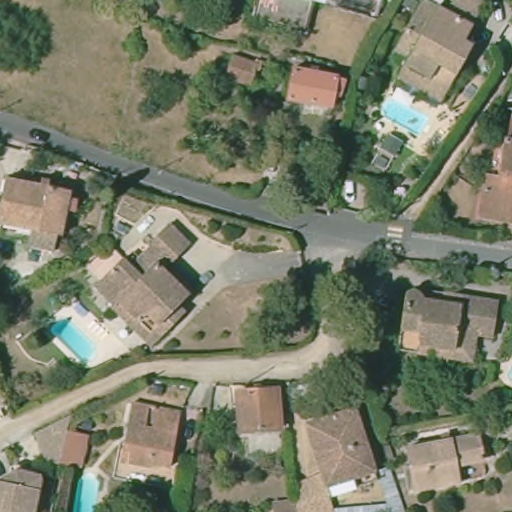

In [19]:
img = Image.open(image_file)
img

In [20]:
!ls $label_file -lh

-rwxrwxrwx 1 root root 1014 Feb 11 17:25 images/labels/CANNES_TILES_512x512.618.xml


In [21]:
with open(label_file, 'r') as f:
    print(f.read())

<annotation>
	<folder>CANNES_TILES_512x512</folder>
	<filename>CANNES_TILES_512x512.618.tif</filename>
	<path>F:\CANNES_TILES_512x512\CANNES_TILES_512x512.618.tif</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>512</width>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>71</xmin>
			<ymin>468</ymin>
			<xmax>105</xmax>
			<ymax>512</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>47</xmin>
			<ymin>315</ymin>
			<xmax>100</xmax>
			<ymax>361</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>377</xmin>
			<ymin>93</ymin>
			<xmax>433</xmax>
			<ymax>139</ymax>
		</bndbox>
	</object>


> The existing references images to .tif files instead of .png files. So let's do the updates to all labels files.

In [23]:
def replace_str1_with_str2(directory_path: str, str1: str, str2: str):
    """
    Replace all occurrences of 'str1' with 'str2' in XML files
    
    Args:
        directory_path: Path to directory containing XML files
    """
    # Find all XML files in the directory
    xml_files = glob.glob(os.path.join(directory_path, '*.xml'))

    if not xml_files:
        print("No XML files found in the directory.")
        return

    processed_count = 0

    for xml_file in xml_files:
        try:
            # Read the file
            with open(xml_file, 'r', encoding='utf-8') as file:
                content = file.read()
            # Replace 'tif' with 'png'
            updated_content = content.replace(str1, str2)
            # Write back only if there were changes
            if updated_content != content:
                with open(xml_file, 'w', encoding='utf-8') as file:
                    file.write(updated_content)
                processed_count += 1
            else:
                print(f"No changes needed: {xml_file}")

        except Exception as e:
            print(f"Error processing {xml_file}: {e}")

    print(f"Done: Updated {processed_count} files in {directory_path}.")

In [24]:
start = time.time()

replace_str1_with_str2(LABELS_DIR, "tif", "png")

minutes, seconds = divmod((time.time() - start), 60)
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Done: Updated 1224 files in images/labels.
Elapsed time = 1 minutes and 15 seconds


> OK now. The XML files no longer include references to the TIFF files

## Label file

In [25]:
label_file

'images/labels/CANNES_TILES_512x512.618.xml'

In [26]:
with open(label_file, 'r') as f:
    print(f.read())

<annotation>
	<folder>CANNES_TILES_512x512</folder>
	<filename>CANNES_TILES_512x512.618.png</filename>
	<path>F:\CANNES_TILES_512x512\CANNES_TILES_512x512.618.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>512</width>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>71</xmin>
			<ymin>468</ymin>
			<xmax>105</xmax>
			<ymax>512</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>47</xmin>
			<ymin>315</ymin>
			<xmax>100</xmax>
			<ymax>361</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>377</xmin>
			<ymin>93</ymin>
			<xmax>433</xmax>
			<ymax>139</ymax>
		</bndbox>
	</object>


## Image with its label

In [27]:
image_file = os.path.join(PNG_DIR, "CANNES_TILES_512x512.618.png")
image_file

'images/png/CANNES_TILES_512x512.618.png'

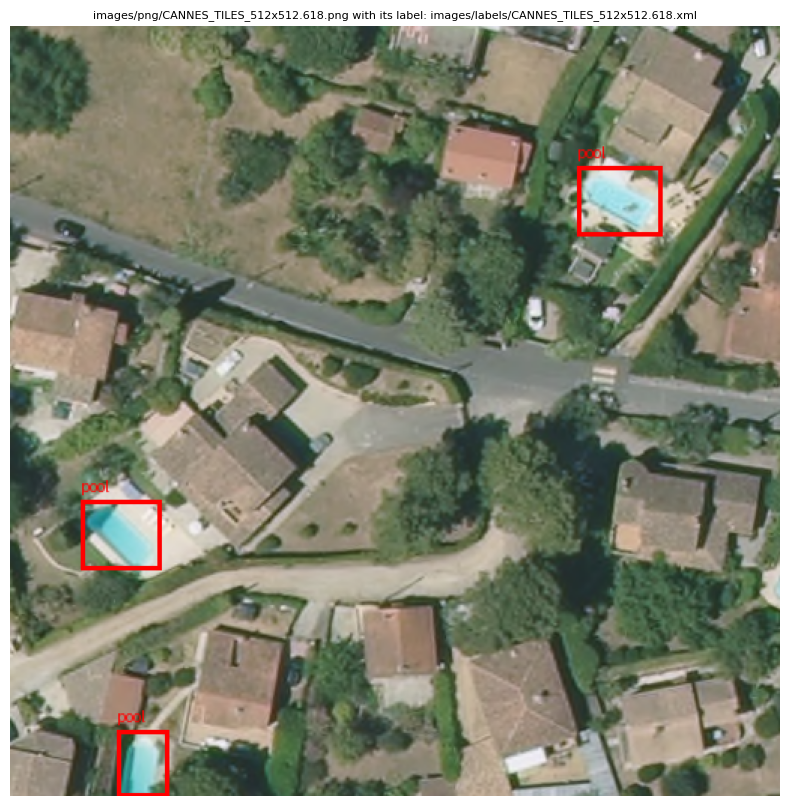

In [28]:
img = Image.open(image_file)

draw = ImageDraw.Draw(img)
tree = ET.parse(label_file)
root = tree.getroot()
color = "red"

for obj in root.findall('object'):
    if obj.find('name').text == 'pool':
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
        draw.text((xmin, ymin - 15), 'pool', fill=color)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title(f"{image_file} with its label: {label_file}", size=8)
plt.show()

In [29]:
nb_png = len([f for f in os.listdir(PNG_DIR) if f.endswith('.png')])
print(f"🖼️ Total of .png images files = {nb_png}")

nb_xml = len([f for f in os.listdir(LABELS_DIR) if f.endswith('.xml')])
print(f"🏷️ Total of .xml labels files = {nb_xml}")

🖼️ Total of .png images files = 827
🏷️ Total of .xml labels files = 1224


## Some images with their labels

In [30]:
nb = 20

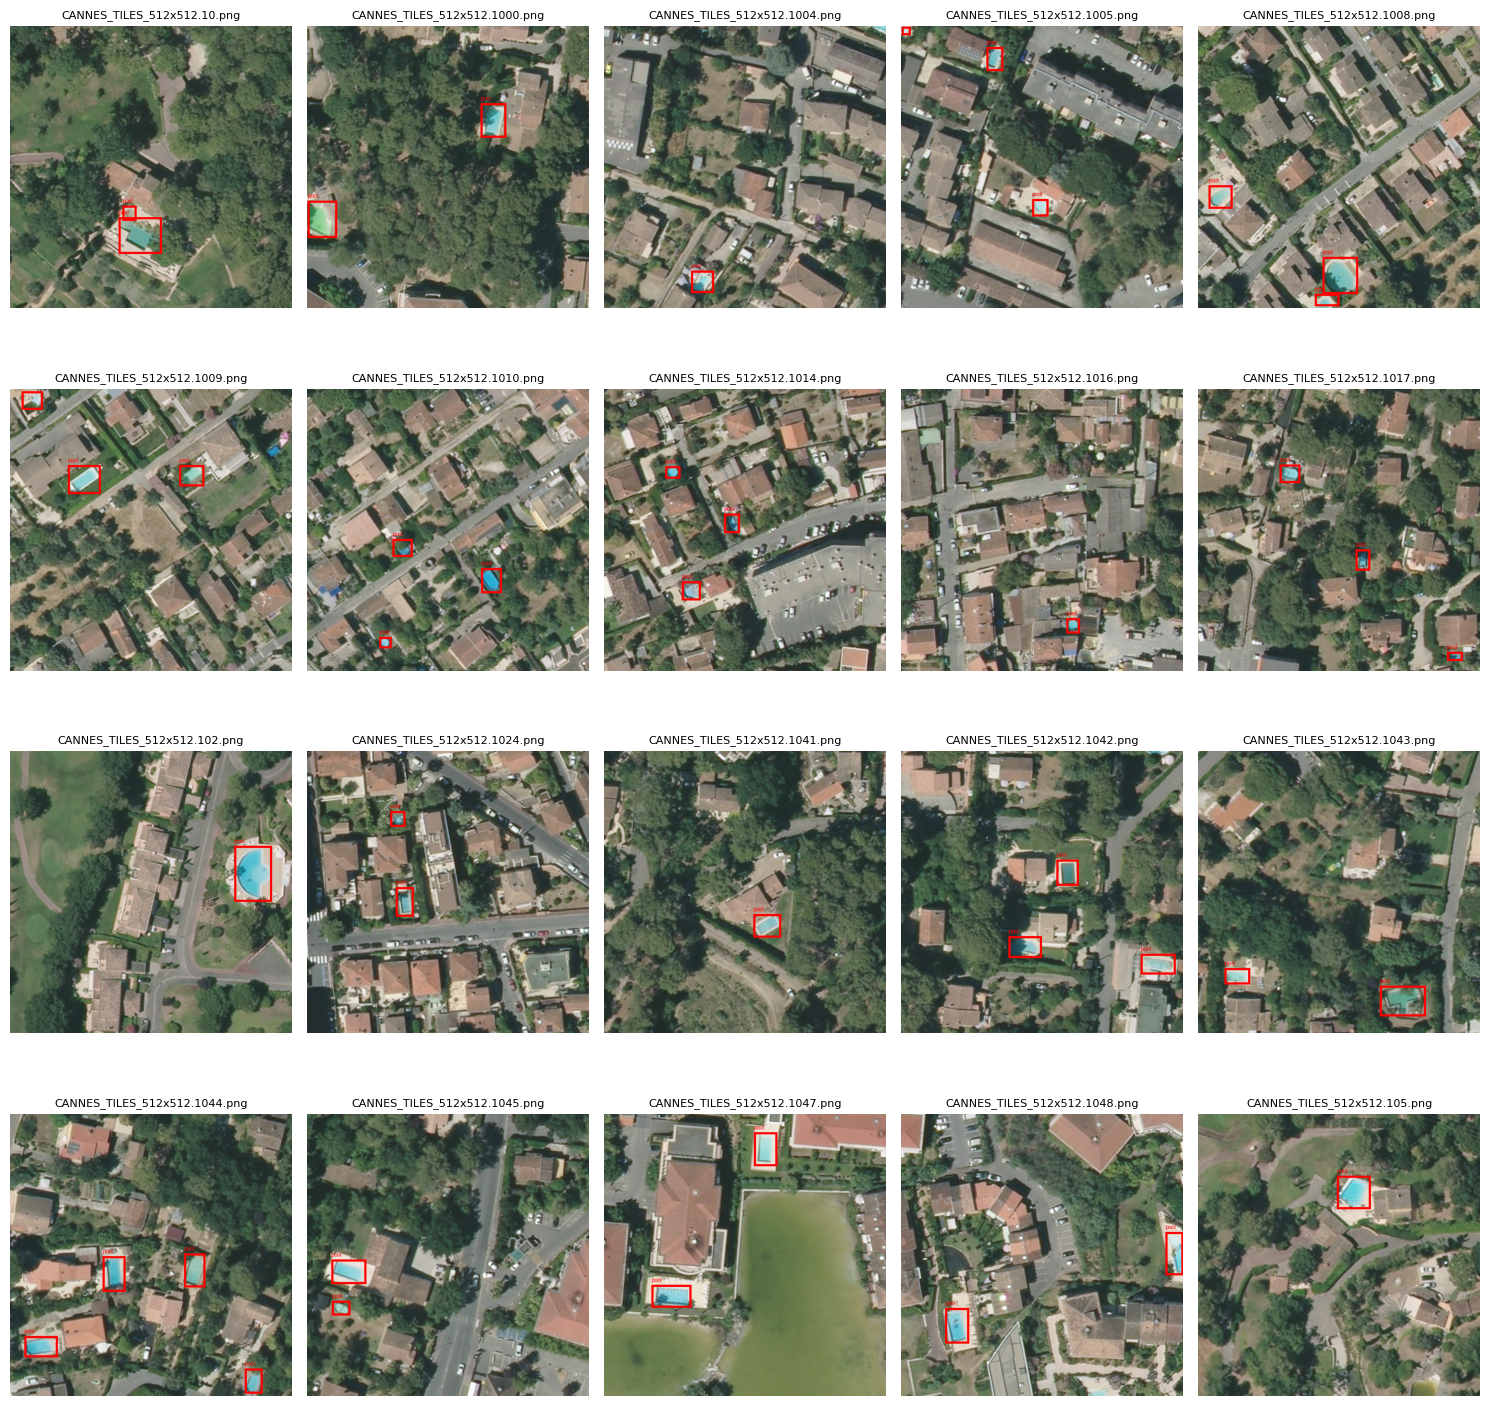

In [31]:
image_files = sorted([
    f for f in os.listdir(PNG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])[:nb]

# Number of cols and rows
cols = 5
rows = int(nb / cols) + (1 if nb % cols else 0)

width = 4
color = "red"
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(PNG_DIR, image_file)
    label_file = image_file.rsplit('.', 1)[0] + '.xml'
    label_path = os.path.join(LABELS_DIR, label_file)
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    if os.path.exists(label_path):
        tree = ET.parse(label_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            if obj.find('name').text == 'pool':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                draw.rectangle([xmin, ymin, xmax, ymax],
                               outline=color,
                               width=width)
                draw.text((xmin, ymin - 15), 'pool', fill=color)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{image_file}", fontsize=8)

plt.tight_layout()
plt.show()

In [32]:
# Generating a df with some images informations

print("Generating the df...")
start = time.time()
data = []

for f in os.listdir(PNG_DIR):
    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(PNG_DIR, f)
        size_bytes = os.path.getsize(file_path)
        size_kb = round(size_bytes / 1024, 2)
        modified_time = datetime.datetime.fromtimestamp(os.path.getmtime(file_path))
        
        with Image.open(file_path) as img:
            width, height = img.size
        
        data.append({
            "image_filename": f,
            "size_kb": size_kb,
            "modified_date": modified_time.strftime("%Y-%m-%d %H:%M:%S"),
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
        })

df = pd.DataFrame(data)

minutes, seconds = divmod((time.time() - start), 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Generating the df...
✅ Done. Elapsed time = 0 minutes and 53 seconds


In [33]:
df

image_filename  size_kb        modified_date  width  \
0      CANNES_TILES_512x512.10.png   378.20  2026-02-11 17:25:32    512   
1    CANNES_TILES_512x512.1000.png   382.01  2026-02-11 17:25:32    512   
2    CANNES_TILES_512x512.1004.png   390.04  2026-02-11 17:25:32    512   
3    CANNES_TILES_512x512.1005.png   383.32  2026-02-11 17:25:32    512   
4    CANNES_TILES_512x512.1008.png   422.81  2026-02-11 17:25:32    512   
..                             ...      ...                  ...    ...   
822   CANNES_TILES_512x512.981.png   348.78  2026-02-11 17:25:38    512   
823   CANNES_TILES_512x512.992.png   409.26  2026-02-11 17:25:39    512   
824   CANNES_TILES_512x512.993.png   377.15  2026-02-11 17:25:39    512   
825   CANNES_TILES_512x512.994.png   371.15  2026-02-11 17:25:39    512   
826   CANNES_TILES_512x512.996.png   379.28  2026-02-11 17:25:39    512   

     height resolution  
0       512    512x512  
1       512    512x512  
2       512    512x512  
3       512    512x512  
4       512    512x512  
..      ...        ...  
822     512    512x512  
823     512    512x512  
824     512    512x512  
825     512    512x512  
826     512    512x512  

[827 rows x 6 columns]

### Export

In [35]:
csv_file = os.path.join(RESULTS_DIR, "images.csv")
df.to_csv(csv_file, index=False)
!ls $csv_file -lh

-rwxrwxrwx 1 root root 59K Feb 11 17:42 results/images.csv
